<a href="https://colab.research.google.com/github/stefanogiagu/DL2023/blob/main/handson/QML_DeepLearn2023_giagu_AnomalyDetectionQAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QUANTUM MACHINE LEARNING ON PARAMETRIZED-QC @ DeepLearn2023 Summer
## Hands-on session

Implementation of a quantum Auto-Encoder trained for anomaly detection of MNIST hand-written digits of zero (normal data) and one (anomalous data)

**Library:** Xanadu [Pennylane framework](https://pennylane.ai)

**Reference:** S. Bordoni, D. Stanev, T. Santantonio, and S. Giagu, “[Long-Lived Particles Anomaly Detection with Parameterized Quantum Circuits](https://www.mdpi.com/2571-712X/6/1/16)”, Particles 2023, 6(1), 297-311

**v 1.0** Tested on Google Colab (no need for GPU acceleration)

In [1]:
# installa torch/pennylane frameworks
!pip install torch
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [2]:
# download datasets

# standrad data: MNIST #0, downsized to (8x8 pixels) and properly normalized in [0,1]
# anomalous data: MNIST #1, downsized to (8x8 pixels) and properly normalized in [0,1]

!wget http://giagu.web.cern.ch/giagu/CERN/standard_data.npy
!wget http://giagu.web.cern.ch/giagu/CERN/anomalous_data.npy

--2023-07-20 15:41:13--  http://giagu.web.cern.ch/giagu/CERN/standard_data.npy
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1767296 (1.7M)
Saving to: ‘standard_data.npy’

standard_data.npy   100%[===================>]   1.68M   663KB/s    in 2.6s    

2023-07-20 15:41:16 (663 KB/s) - ‘standard_data.npy’ saved [1767296/1767296]

--2023-07-20 15:41:16--  http://giagu.web.cern.ch/giagu/CERN/anomalous_data.npy
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2016640 (1.9M)
Saving to: ‘anomalous_data.npy’

anomalous_data.npy  100%[===================>]   1.92M   536KB/s    in 3.7s    

2023-07-20 15:41:20 (536 KB/s) - ‘anomalou

In [3]:
# imports

import pennylane as qml
import torch
from torch.autograd import Variable
from pennylane import numpy as np
import matplotlib.pyplot as plt

(6903, 64)
(7877, 64)


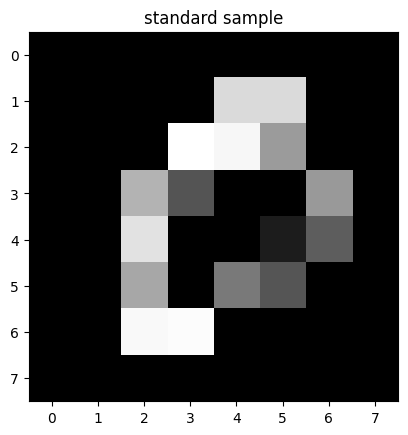

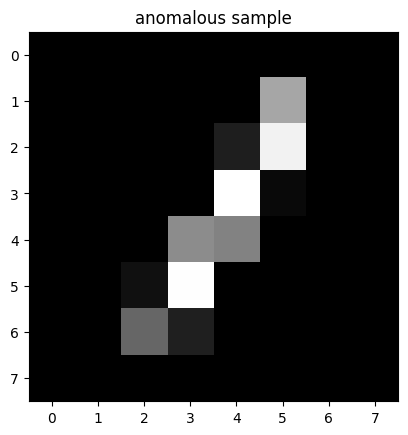

Len train set:  5000
Let test set:  1903


In [4]:
# Load and visualize data
standard_data_np = np.load("standard_data.npy")
anomalous_data_np = np.load("anomalous_data.npy")
print(standard_data_np.shape)
print(anomalous_data_np.shape)

plt.imshow(np.reshape(standard_data_np[0], (8,8)), cmap="gray")
plt.title("standard sample")
file_plot = "standard_sample.png"
plt.show()
#plt.savefig(file_plot)
#plt.close()

plt.imshow(np.reshape(anomalous_data_np[4], (8,8)), cmap="gray")
plt.title("anomalous sample")
file_plot = "anomalous_sample.png"
#plt.savefig(file_plot)
#plt.close()
plt.show()

# Define train set size, the rest will be used for test
train_size = 5000

train_set = torch.tensor(standard_data_np[0:train_size])
standard_data_test = torch.tensor(standard_data_np[train_size:])
anomalous_data_test = torch.tensor(anomalous_data_np)

print("Len train set: ", len(train_set))
print("Let test set: ", len(standard_data_test))

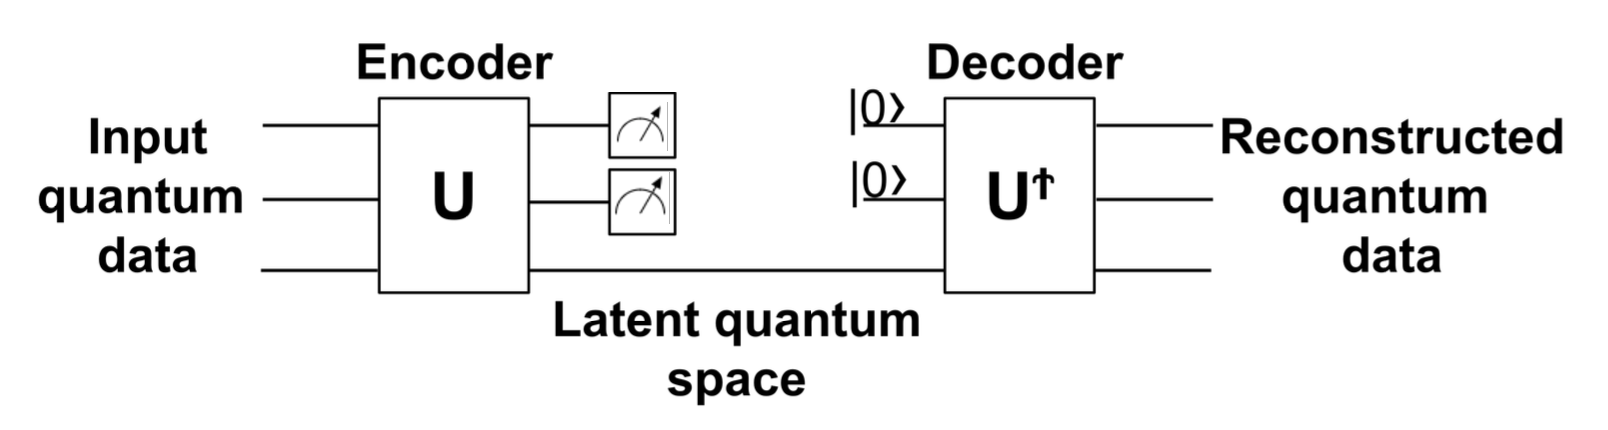

In [5]:
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/QAE.png', width=800)

### Quantum Auto-Encoder

A quantum circuit implements a unitary, thus invertible, transformation on the initial state. This represents a great advantage to implement a quantum autoencoder architecture, as the decoder can be taken as simply the inverse of the encoder quantum circuit. So we can model the encoder with a parametric circuit $U(\theta)$, and the decoder then will just be the conjugate transpose $U^\dagger(\theta)$.

In order to compress information, we discard a certain number of qubits. If th eoutput of the discarded qubits is a fixed pure state (like $|0\cdots 0\rangle$), then is possible to demosntrate that the the autoencoder reaches lossless compression (see: [Bravo-Prieto, C. Quantum autoencoders with enhanced data encoding](http://dx.doi.org/10.1088/2632-2153/ac0616)). Moreover discarding some of the qubits makes possible to define a simple local cost function (eg only part of the qubits are readout), mitigating the risk of
suffering from Barren plateuas issues.

In practice we will implement the encoder circuit in order to disentangle and set to a fixed state a given number of qubits over the total input qubits. The loss function to minimize is thus taken as the expected measurement values of these qubits. In pennylane an egienvalue +1 is associated to zero state, and -1 to one state, this way to mimize the loss corresponds to set the qubits to one state.  **In this way, for the training of the circuit, only the encoder is necessary.**



In [26]:
# Define quantum device

# we need 6 quibit to encode 64 pixels (64=2^6)
dev = qml.device("default.qubit", wires=6)


# helper function defining the quantum circuit for the encoder architecture
def encoder_architecture(params, n_layers, n_qubits, q_compression):
  index = 0
  for i in range(n_layers):

      # Rotation layer
      for j in range(n_qubits):
          qml.RX(params[index], wires=j)
          qml.RY(params[index + 1], wires=j)
          qml.RZ(params[index + 2], wires=j)
          index += 3

      # Entangling layer
      for j in range(n_qubits):
          qml.CNOT(wires=[j, (j + 1) % n_qubits])

  # Final rotations on the discarded (compressed) qubits
  for j in range(q_compression):
      qml.RX(params[index], wires=j)
      qml.RY(params[index + 1], wires=j)
      qml.RZ(params[index + 2], wires=j)
      index += 3

# Quantum encoder pipeline
@qml.qnode(dev, interface='torch')
def encoder(params, state, return_state=False, n_layers = 3, n_qubits = 6, q_compression = 3):

    # Prepare initial state (ok in simulation, allows to skip quantum encoding of the classical data,
    # requires the input to be pre-normalized as a quantum state)
    qml.QubitStateVector(state, wires=range(6))

    # Real quantum encoding (using amplitude encoding). If you want to use it comment previous line and uncomment this ...
    #qml.AmplitudeEmbedding(features=state, wires=range(6))

    # Quantum circuit
    encoder_architecture(params, n_layers, n_qubits, q_compression)

    if return_state:
      return qml.state()

    # Return the Z expectation values for the compressed qubits
    # NOTE: we minimize this values that are 1: |0> or -1: |1>. So minimizing implies to force the qubit to be |1>
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(q_compression)]

In [27]:
# Hyper-parameters of the autoencoder
n_layers = 4
n_qubits = 6
q_compression = 3

# Initialize parameters
n_params = (n_layers * n_qubits + q_compression) * 3
params = Variable(torch.normal( mean=0. , std=0.1, size=(n_params,)), requires_grad=True)

# Set the state to the first event of the training set
state = train_set[0]

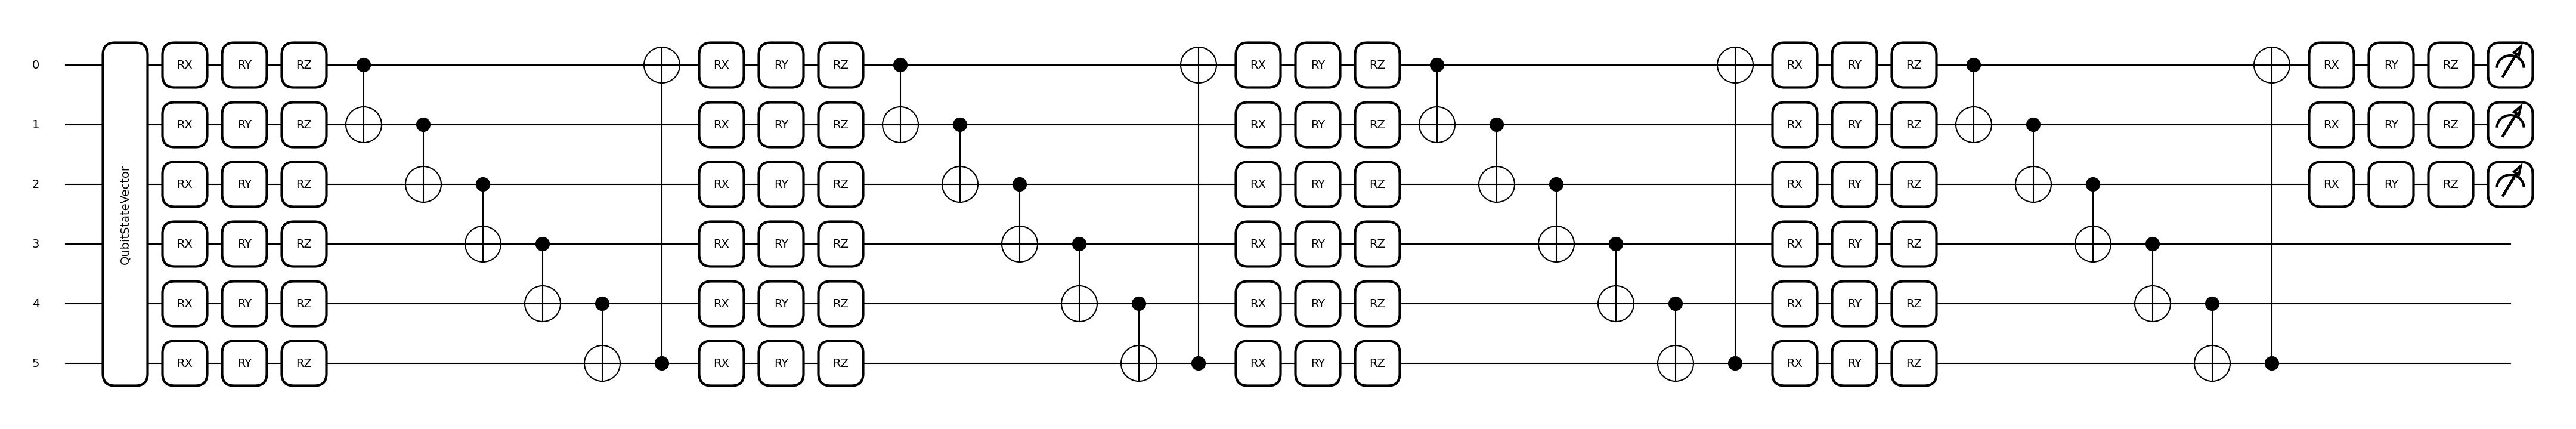

In [28]:
# visualize the encoder

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(encoder)(params, state, False, n_layers, n_qubits, q_compression)
plt.show()

In [29]:
# Training hyperparameters
epochs = 10
batch_size = 64
steps_per_epoch = int(train_size/batch_size)
optimizer = torch.optim.Adam([params], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1 , gamma=0.7)

# dataloader
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

loss_history = []
params_history = []

# Training Loop
for epoch in range(epochs):
  tot_loss = 0.
  for batch in data_loader:
    optimizer.zero_grad()
    expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
    loss = expvals[0].mean() + expvals[1].mean() + expvals[2].mean()
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().numpy()
  loss_history.append(tot_loss/steps_per_epoch)
  params_history.append(params)
  scheduler.step()
  print("Epoch {}: avg_loss = {}".format(epoch+1, tot_loss/steps_per_epoch))

Epoch 1: avg_loss = -1.7007285966643555
Epoch 2: avg_loss = -2.016250135441527
Epoch 3: avg_loss = -2.057377238892074
Epoch 4: avg_loss = -2.071310946640932
Epoch 5: avg_loss = -2.0732144476495424
Epoch 6: avg_loss = -2.0756495208040526
Epoch 7: avg_loss = -2.0777962168464645
Epoch 8: avg_loss = -2.0778758343510506
Epoch 9: avg_loss = -2.0791272484466705
Epoch 10: avg_loss = -2.0794476323885607


In [31]:
# Evaluation

test_set_size = len(standard_data_test)
print("Test set size: ", test_set_size)

standard_data_loader = torch.utils.data.DataLoader(standard_data_test, batch_size=256, shuffle=False, drop_last=False)
anomalous_data_loader = torch.utils.data.DataLoader(anomalous_data_test[0:len(standard_data_test)], batch_size=256, shuffle=False, drop_last=False)
loss_s = np.asarray([])
loss_a = np.asarray([])

with torch.no_grad():
    # Standard data
    for batch in standard_data_loader:
      expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
      loss = expvals[0].numpy() + expvals[1].numpy() + expvals[2].numpy()
      loss_s = np.concatenate([loss_s,loss])
    # Anomalous data
    for batch in anomalous_data_loader:
      expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
      loss = expvals[0].numpy() + expvals[1].numpy() + expvals[2].numpy()
      loss_a = np.concatenate([loss_a,loss])

Test set size:  1903


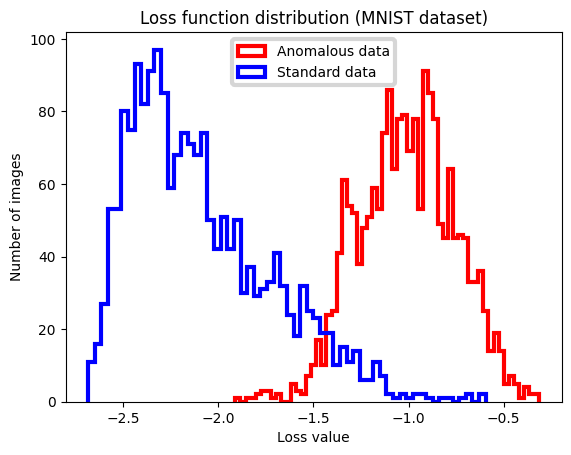

In [32]:
# Loss function plot
plt.hist(loss_a, bins=60, histtype="step", color="red", label="Anomalous data")
plt.hist(loss_s, bins=60, histtype="step", color="blue", label="Standard data")
plt.ylabel("Number of images")
plt.xlabel("Loss value")
plt.title("Loss function distribution (MNIST dataset)")
plt.legend()
#file_plot = "loss_distribution.png"
#plt.savefig(file_plot)
plt.show()
plt.close()

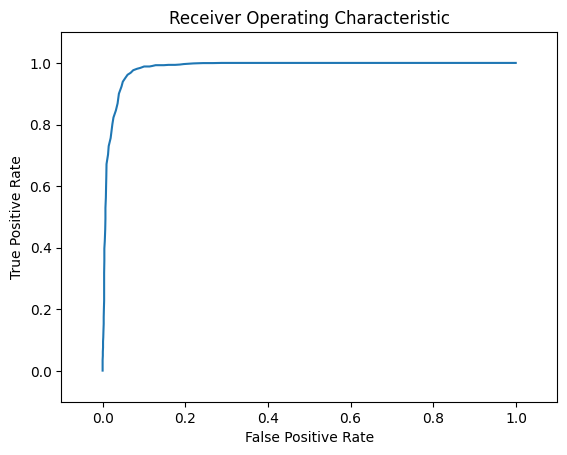

In [33]:
# Roc
max1 = np.amax(loss_s)
max2 = np.amax(loss_a)
ma = max(max1, max2)
min1 = np.amin(loss_s)
min2 = np.amin(loss_a)
mi = min(min1, min2)

tot_neg = len(loss_s)
tot_pos = len(loss_a)

n_step = 100.0
n_step_int = 100
step = (ma - mi) / n_step
fpr = []
tpr = []
for i in range(n_step_int):
    treshold = i * step + mi
    c = 0
    for j in range(tot_neg):
        if loss_s[j] > treshold:
            c += 1
    false_positive = c / float(tot_neg)
    fpr.append(false_positive)
    c = 0
    for j in range(tot_pos):
        if loss_a[j] > treshold:
            c += 1
    true_positive = c / float(tot_pos)
    tpr.append(true_positive)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
#file_plot = "ROC.png"
#plt.savefig(file_plot)
plt.show()
plt.close()

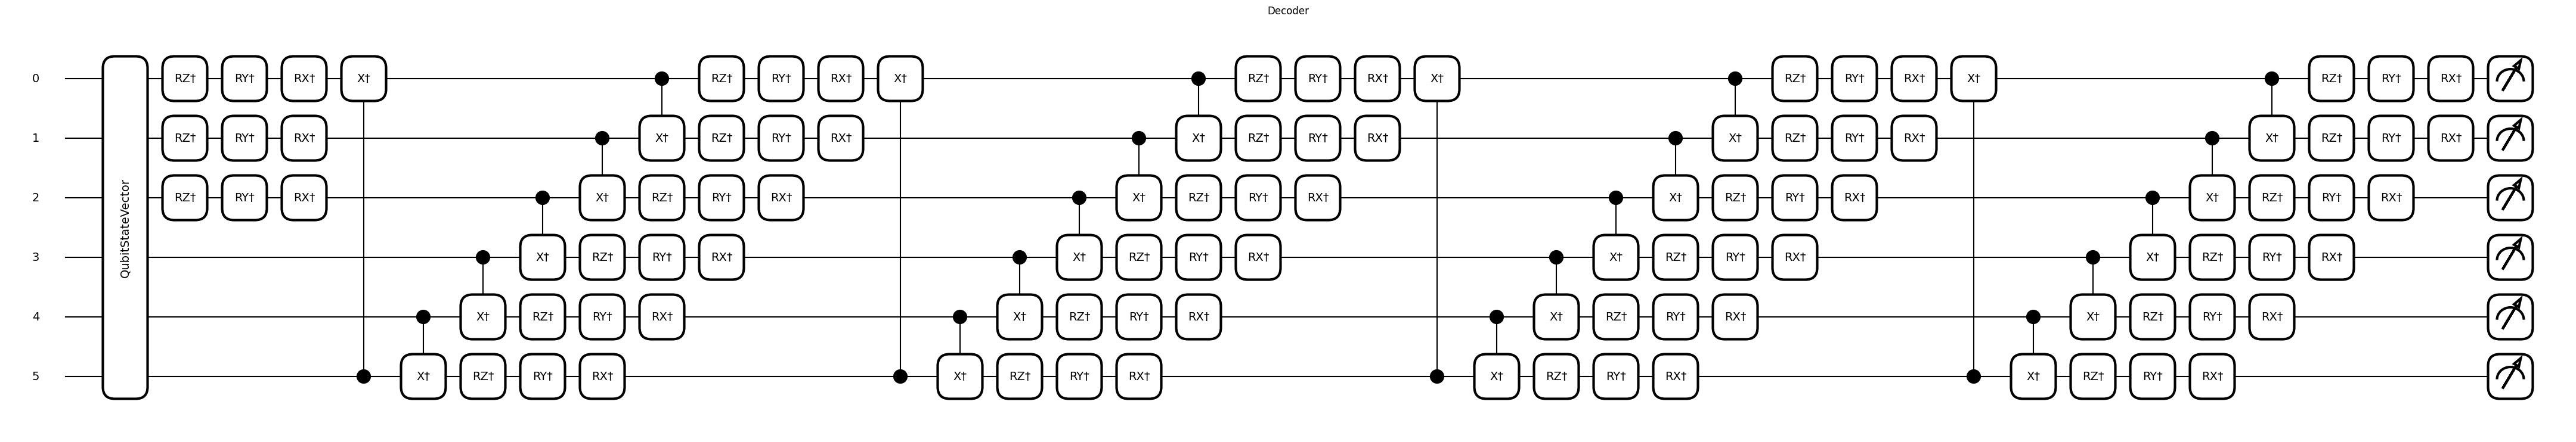

In [34]:
# Decoder part

@qml.qnode(dev, interface='torch')
def decoder(params, state, n_layers, n_qubits, q_compression):
    # Prepare initial state
    qml.QubitStateVector(state, wires=range(6))
    # Real quantum encoding (using amplitude encoding). If you want to use it comment previous line and uncomment this ...
    #qml.AmplitudeEmbedding(features=state, wires=range(6))


    # Quantum circuit (encoder inverse)
    qml.adjoint(encoder_architecture)(params,  n_layers, n_qubits, q_compression) #qml.adjoint compute the transpose conjugate to an input unitary
    return qml.state()

def prepare_decoder_input(latent_space):
  decoder_input = np.zeros((64,), dtype=complex)
  decoder_input[-len(latent_space):] = latent_space
  # Normalize
  norm = np.linalg.norm(decoder_input)
  decoder_input = decoder_input/norm
  return torch.tensor(decoder_input)

# Visualize_decoder
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(decoder)(params, standard_data_test[0], n_layers, n_qubits, q_compression)
plt.title("Decoder")
plt.show()
plt.close()

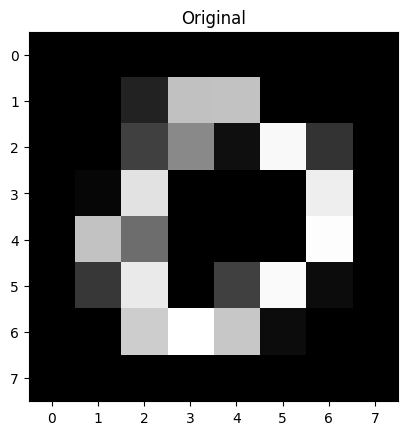

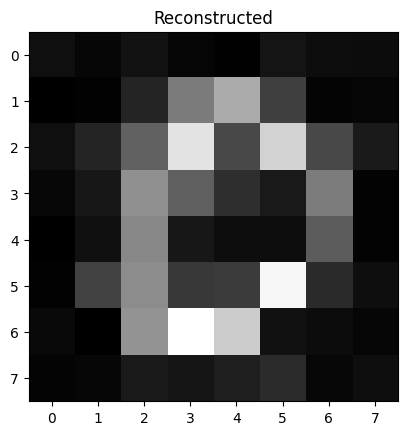

In [36]:
# example on how to use the full outencoder to reconstruct examples

compression = 56 # for 3 out of 6 compressed qubits: compression = 2^5+2^4+2^3
sample = standard_data_test[0] # generate 0
#sample = anomalous_data_test[0] #generate 1
plt.imshow(np.reshape(sample, (8,8)), cmap="gray")
plt.title("Original")
plt.show()
plt.close()
with torch.no_grad():
  final_state = encoder(params, sample, True, n_layers, n_qubits, q_compression).numpy()
  latent_space = final_state[compression:]
  decoder_input = prepare_decoder_input(latent_space)
  reconstructed = np.absolute(decoder(params, decoder_input, n_layers, n_qubits, q_compression).numpy())
plt.imshow(np.reshape(reconstructed, (8,8)), cmap="gray")
plt.title("Reconstructed")
plt.show()
plt.close()